In [ ]:
import numpy as np
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
import math
# Set up the environment 
randomseednumber = 11022018

from opossum import UserInterface
import matplotlib.pyplot as plt
import causalml
from causalml.inference.meta import LRSRegressor
from xgboost import XGBRegressor
from causalml.inference.meta import BaseRRegressor

In [2]:
################################################################################################################
### GET A DATASET. 
################################################################################################################
N = 1000
k = 10
u = UserInterface(N, k, seed=5, categorical_covariates = None)
## confounding of covariates, clear treatment effect
u.generate_treatment(random_assignment = False, 
                     assignment_prob = 'low', 
                     constant_pos = True, 
                     constant_neg = False,
                     heterogeneous_pos = False, 
                     heterogeneous_neg = False, 
                     no_treatment = False, 
                     discrete_heterogeneous = False,
                     treatment_option_weights = None, 
                     intensity = 10)

y, X, assignment_confoundedC_clearT, treatment = u.output_data(binary=False, 
                                               x_y_relation = 'nonlinear_interaction')






In [3]:
### YOU NEED TO ESTIMATE YOUR OWN PROPENSITY SCORES.
### CAUSAL ML PROPENSITY SCORE ESTIMATION:

from causalml.propensity import ElasticNetPropensityModel
pm = ElasticNetPropensityModel(n_fold=5, random_state=42)
estimatedpropensityscores = pm.fit_predict(X, assignment)


rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=X, treatment = assignment, p=estimatedpropensityscores, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))





Average Treatment Effect (BaseRRegressor using XGBoost): 1.89 (1.88, 1.90)


In [ ]:
#*********************************************************************************************************************
#******************************************* trying something else ***************************************************
#*********************************************************************************************************************

Nie and Wager: we propose building a consensus estimate ˆτ(·) by taking the
best positive linear combination of the ˆτ_k(·).

some issues:
there is some cross fitting here,

N&W use 10 X vars

how is the R learner from nie wager different to stackng models? 
check: model averageing with the R learner -- 'Here, we discuss how to use the R-learning approach
to build a consensus treatment effect estimate via a variant of stacking'

ie what defines the R learner is the loss funciton. 
-> we first estimated ˆe(·) and ˆm(·) to form the R-loss function 

1.) __fit models for the nuisance components__ via both boosting and the lasso (both
with tuning parameters selected via cross-validation), and chose the model that minimized
cross-validated error. Perhaps unsurprisingly noting the large sample size, this criterion
lead us to pick boosting for both ˆe(·) and ˆm(·).

2.) Next, we __optimized the R-loss function__. We again tried methods based on both the lasso
and boosting. This time, the lasso achieved a slightly lower training set cross-validated
R-loss than boosting. We thus __chose the lasso-based ˆτ(·) fit as our final model for τ∗(·).__


>>>> the model is the loss funciton plus the regularizer on treatment effect.
the loss function: choose t() to minimise the loss function, which contains in it the propensity sore and the nuisance functon.

>>>> the stacking should then happen on the different way we can estimate the treatment t().  
>>>> ie etsimate 

Because we know the true CATE function τ∗(·) in our semi-synthetic data
generative distribution, we can evaluate the oracle test set mean-squared error. _It thus appears that, in this example, there is value in using a non-parametric method for estimating ˆe(·) and ˆm(·), but then using the simpler
lasso for ˆτ (·)._


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
THE STACKING PART
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Nie and Wager talk about stacking to estimate the t() "function", not the propensity or the nuisance funciton. 
== allow the stacking step (12) to freely adjust a constant treatment effect term c, and we add an intercept b that can be used to absorb any potential bias of ˆm. (implying that there is a common m(), for each method of estimating the treatment effect, use same m()...)

1.) tried __estimating τ (·) via BART, causal forests, and a stacked combination of the two using OLS__. We assume
that the experimenter knows that the data was randomized, and used ˆe(x) = 0.5 in any place
a propensity score was needed. __For stacking, we estimated ˆm(·) using a random forest.__

(^^DOES THIS MEAN THAT THEY USED BART AND CAUSAL FOREST TO ESTIMATE M AND E FOR THE SINGLE R LEARNERS??)

!!!!! they also mention having good out-of-fold estimates for m() and e() and im not sure what they mean here. 
!!!!! Out-of-Fold Predictions: Predictions made by models during the k-fold cross-validation procedure on the holdout examples.

SO: does causal ml have functonality for this? 
the -i index signifies out of fold etimate



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
WHAT DOES IT MEAN ABOUT CONDITIONAL VS AVERAGE TREATMENT EFFECTS ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

THEY DONT REALLY LOOK AT IT. the R, T and U learners all generate predicitons for CATE, S learner only average.
they do it by plotting a histogram of the predicted CATE. 
the histogram means that the y axis is just the count. for some reason they call it the 'number of samples'.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
MODEL VALIDATIOON MEANS WHAT ALSO? ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
deal with that later. 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NOW YOU NEED:
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

1.) a stacking library. OR figure out if a stacking method in causalML package exists.
  
FOR STACKING -- choosing one data type :
1.) do the first step of estimating e() and m() the same way for all. consider like in Nie and Wager. YOU MUST BE ABLE TO DO THIS IN CAUSALML PACKAGE.
2.) do the second step of estimating the treatment effect in different ways. this you can also do in causalML.

    WHAT ARE THEY CALLING THE BASE R REGRESSOR? THE REGROSSOR THAT ESTIMATES WHAT?
    
    i assume the base R regressor is estimating the baseline m() function???
    propensity score is estimated by ElasticNetPropensityModel() --- we can just leave it like that.
    so what does the predict_ate function use for predicting the outcome?

causalml.inference.meta.BaseRLearner(learner=None, outcome_learner=None,...)

theres a learner and an outcome_learner. what do those mean? and what learners are available? 
lerner can be, ZB: XGBRegressor()

GET THEM FROM from : sklearn.linear_model OR sklearn.somethg else???

FROM THE DOCS:

        """Initialize an R-learner.

        Args:
            learner (optional): a model to estimate outcomes and treatment effects
            outcome_learner (optional): a model to estimate outcomes
            effect_learner (optional): a model to estimate treatment effects. It needs to take `sample_weight` as an
                input argument for `fit()`
            ate_alpha (float, optional): the confidence level alpha of the ATE estimate
            control_name (str or int, optional): name of control group
            n_fold (int, optional): the number of cross validation folds for outcome_learner
            random_state (int or RandomState, optional): a seed (int) or random number generator (RandomState)
        """

In [6]:
## the following code will output : the lower bound, estimate, and upper bound of the average treatment effect.

# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment = assignment, p=estimatedpropensityscores, y=y)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression

## comes from from sklearn.linear_model import LinearRegression.. so i assume all can come from there???
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment = assignment, p=estimatedpropensityscores, y=y)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

## SO THIS R LEARNER IS JUST DOING THE FITTING MODELS FOR NUISANCE COMPONENTS. 

### how do we get the true function / actual treatment effect from the opossum library.

Using the BaseRRegressor class and using XGB:
(array([1.52288837]), array([1.51223661]), array([1.53354012]))
Using the BaseRRegressor class and using Linear Regression:
(array([1.5744664]), array([1.56623173]), array([1.58270108]))


>knn -101.019 (7.161)
>cart -147.474 (10.851)
>svm -162.419 (12.565)


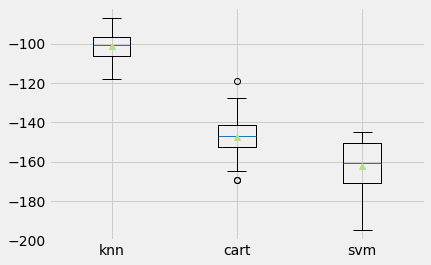

In [7]:
####### THE STACKING PART
# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot

# get the dataset
def get_dataset():
	X, y = make_regression(n_samples=1000, n_features=20, n_informative=15, noise=0.1, random_state=1)
	return X, y

# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()